# The Enhancement and Automated Counting of Bats

# Placing Bats Randomly in an Image

- **Benjamin Bowman**
  - Email: [bbowman9114@floridapoly.edu](mailto:bbowman9114@floridapoly.edu)
- **Zhi Zheng**
  - Email: [zhizheng0889@floridapoly.edu](mailto:zhizheng0889@floridapoly.edu)
- **Nesreen Dalhy**
  - Email: [ndalhy8095@floridapoly.edu](mailto:ndalhy8095@floridapoly.edu)
- **Brendan Geary**
  - Email: [bgeary6291@floridapoly.edu](mailto:bgeary6291@floridapoly.edu)



## Create Image with n by n buffer

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt


def quickshow(img):
    plt.imshow(img, cmap= 'gray', vmin=0, vmax=255)
    plt.axis('off')  # Turn off axis
    plt.show()

## Randomly Place Points and Calculate Euclidian Distance

In [3]:
import numpy as np

In [4]:
import random 

def random_point(n)->tuple:
    return np.random.randint(0, n + 1), np.random.randint(0, n + 1)

def too_close(point: tuple, lst: list, thresh: float)->bool:
    """
    Returns True if distance is under thresh, False if it's further
    """
    for other in lst:
        distance = np.linalg.norm(np.array(point) - np.array(other))
        if distance <= thresh:
            return True
    return False

def bat_coords(n, thresh, img_size=40):
    points_list = []
    
    if thresh < 3:
        scaling_value = 0.3
        smallest_point = 20
    elif thresh < 6:
        scaling_value = 0.2
        smallest_point = 25
    elif thresh < 8:
        scaling_value = 0.3
        smallest_point=30
    elif thresh < 11:
        scaling_value = 0.2
        smallest_point =30
    else:
        smallest_point = 35
        scaling_value = 0.1

    width = img_size * scaling_value
    while True:
        attempt_count = 0
        points_list = []
        for _ in range(50):
            p1 = random_point(smallest_point)
            if attempt_count > 5:
                break
            if too_close(p1, points_list, width):
                attempt_count+=1
                continue
            points_list.append(p1)
            if len(points_list)==n:
                return points_list

In [5]:
def write_to_text(bat_boxes, folder_path, image_name):
    with open(f"{folder_path}/{image_name}.txt", "w") as f:
        positions, dimensions = bat_boxes
        f.write("1 ")
        for x, y in positions:
            f.write(f"{x} {y} ")
        for w, h in dimensions:
            f.write(f"{w} {h} ")

# write_to_text(([[0,1],[1, 1]], [[2,2], [2,3]]), "Data_folder", "image_name")

In [6]:
point, other = bat_coords(2, 20, 2)
np.linalg.norm(np.array(point) - np.array(other))

10.0

## Rotate an Image

In [7]:
import os
import random
import cv2

### Load random Image

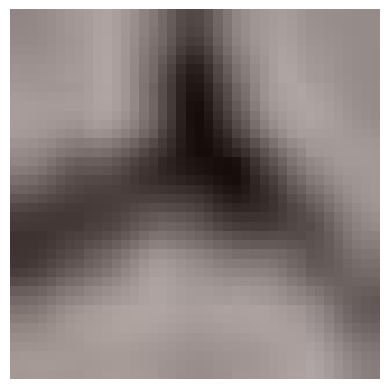

In [8]:

def load_random(directory):
    files = os.listdir(directory)
    image_path = random.choice(files)
    image_path = os.path.join(directory, image_path)
    image = cv2.imread(image_path)
    # if image.shape[2] > 1:
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image
test_img = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
quickshow(test_img)

### Segment The Image

In [9]:
def mask_with_Kmeans(image, reverse=False):
    """
    If the bat is darker than the background 
    """
    if reverse:
        image = 255-image
    pixel_values = image.reshape((-1, image.shape[-1]))
    k = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(np.float32(pixel_values), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    binary_mask = np.uint8(labels.reshape(image.shape[:2]))

    # Make masking consistant! Takes the mean of the estimated object and background and if the "object" is lighter color swap the two.
    # This assumes that the bats will always be darker than the background, if this is not true
    # invert the image before it is given to this function.
    if cv2.mean(image, mask=binary_mask) > cv2.mean(image, mask=~binary_mask):
        binary_mask = ~binary_mask
    max_val = binary_mask.max()
    min_val = binary_mask.min()
    binary_mask[binary_mask==max_val]=255
    binary_mask[binary_mask==min_val]=0

    return binary_mask

**Testing the Functions:**
* `load_random()`
* `mask_with_Kmeans()`

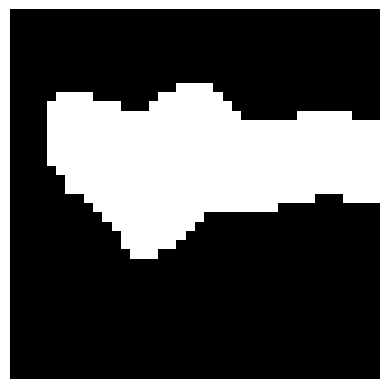

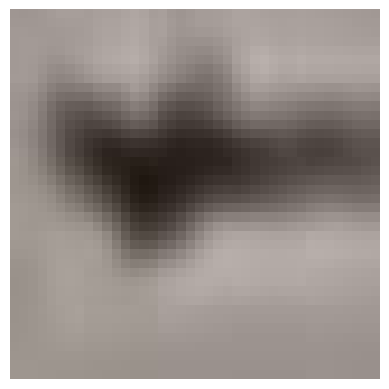

In [10]:
image = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
# print(image)
image_mask = mask_with_Kmeans(image)
# quickshow(~image_mask)
quickshow(image_mask)

quickshow(image)

## Rotate an Image

In [11]:
from PIL import Image
import random

def rotate_img(img, theta=45):
    PIL_img = Image.fromarray(img)
    theta_1 = random.uniform(-theta, theta)
    rotated_image = PIL_img.rotate(theta_1)
    return np.asarray(rotated_image)



255 0


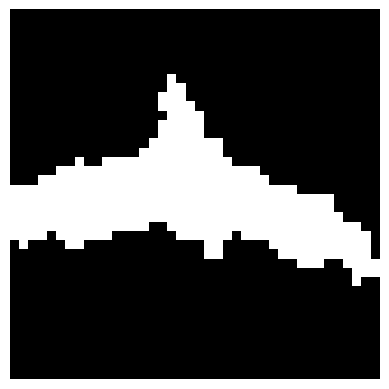

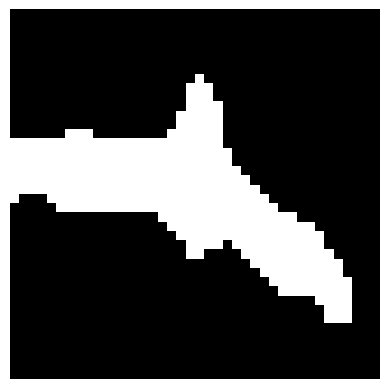

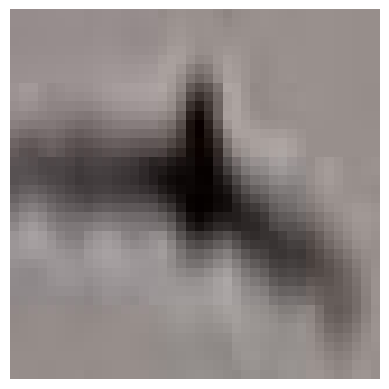

In [12]:
img_test = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
masked_img = mask_with_Kmeans(img_test)
print(masked_img.max(), masked_img.min())
rotated_img = rotate_img(masked_img)

quickshow(rotated_img)
quickshow(masked_img)
quickshow(img_test)

## Placing Images on Background

### Placing images on new Background

In [13]:
from PIL import Image, ImageFilter, ImageEnhance
def add_noise(image, factor):
    enhancer = ImageEnhance.Color(image)
    noisy_image = enhancer.enhance(factor)
    return noisy_image

def add_blur(image, radius):
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius))
    return blurred_image

[(16, 21), (6, 24), (11, 3), (4, 12), (25, 4)]


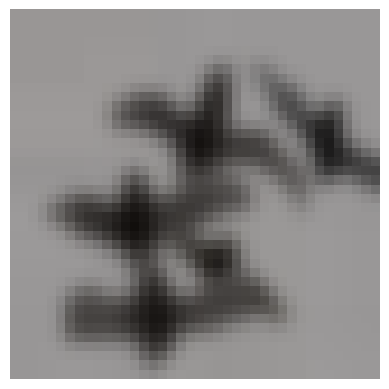

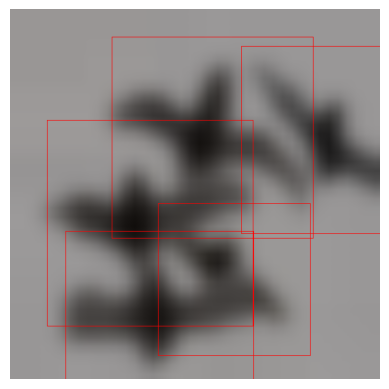

(640, 640, 3)

In [14]:
def place_image(img, mask, bkg, coords):
    x, y = coords
    image = Image.fromarray(img)
    masked = Image.fromarray(mask)
    background = Image.fromarray(bkg)
    background.paste(image, (x, y), mask=masked)
    return np.asarray(background)


def shrink_image(img, k):
    image = Image.fromarray(img)
    width, height = image.size
    if k < 4:
        new_width = random.uniform(0.5, 0.8)
    elif k < 8:
        new_width = random.uniform(0.4, 0.6)
    else:
        new_width = random.uniform(0.3, 0.4)


    w = int(width*new_width)
    return np.asarray(image.resize((w, w))), (new_width, new_width)
number_of_bats = 5


background = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\0')
coords = bat_coords(number_of_bats, number_of_bats)
print(coords)
dim_labels = []
for i in range(number_of_bats):
    image = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
    image, bat_dim = shrink_image(image, number_of_bats)
    dim_labels.append(bat_dim)
    masked_img = mask_with_Kmeans(image)
    
    background = place_image(image, masked_img, background, coords[i])

bkg = Image.fromarray(background)
bkg = add_noise(bkg, 0.3)
bkg = add_blur(bkg, 1)

bkg = np.asarray(bkg)

x_y_labels = np.asarray(coords)/40
write_to_text((x_y_labels, dim_labels), "Data_folder", "test_img")
quickshow(bkg)
boxes = bkg.copy()
# print(boxes.shape)

boxes = cv2.resize(boxes, (640, 640))

with open(r'Data_folder\test_img.txt', 'r') as f:
    file_contents = f.read()
    words = file_contents.split()
    bat_class = words[0]
    bounding_boxes = words[1:]
    x_ys= bounding_boxes[:len(bounding_boxes)//2]
    w_hs= bounding_boxes[len(bounding_boxes)//2:]
    positions = np.asarray([np.asarray([x_ys[i], x_ys[i+1]]) for i in range(0, len(x_ys), 2)]).astype(float)
    dimensions = np.asarray([np.asarray([w_hs[i], w_hs[i+1]]) for i in range(0, len(w_hs), 2)]).astype(float)
    positions=(positions*boxes.shape[0]).astype(int)
    dimensions=(dimensions*boxes.shape[0]).astype(int)
    for (x,y), (w,h) in zip(positions, dimensions):
        cv2.rectangle(boxes, (x,y), (x+w, y+h), (255), 1)
quickshow(boxes)
boxes.shape

# Final Output Creation

In [19]:
for i in range(2, 13):
    os.mkdir(f'Final Testing Dataset/{i}')

In [ ]:
output_folder = 'Final Testing Dataset' # Folder and it's subdirectories must be made prior to running this chunk (cause I'm lazy)

for number_of_bats in [5, 6, 7, 8]:
    for i in range(0, 500):
        print(f"Round {i}")
        for target in ['emergence']:
            background = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\0')
            coords = bat_coords(number_of_bats, number_of_bats)
            for x, y in coords:
                image = load_random(fr'Bats\Bats\Cropped Count Images\NewCroppedImages ({target})\1')
                image, _ = shrink_image(image, number_of_bats)
                masked_img = mask_with_Kmeans(image)
                background = place_image(image, masked_img, background, (x,y))
                
            img_to_save = Image.fromarray(background)
            img_to_save = add_blur(img_to_save, 1)
            img_to_save = img_to_save.convert("L")
            img_to_save.save(fr'{output_folder}\{number_of_bats}\{target}_{i}.jpg')

In [ ]:
folder = r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1'
target_folder = r'Final Testing Dataset\1'
for index, element in enumerate(os.listdir(folder)):
    if index > 500:
        break
    file_path = os.path.join(folder, element)
    print(file_path)
    target_path = os.path.join(target_folder, element)
    Image.open(file_path).save(target_path)

## Instance Seg synthetic Data

In [ ]:
output_folder = 'Instance_seg' # Folder and it's subdirectories must be made prior to running this chunk (cause I'm lazy)

for number_of_bats in [2,3,4, 5, 6]:
    for i in range(0, 2000):
        # print(f"Round {i}")
        for target in ['emergence']:
            background = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\0')
            coords = bat_coords(number_of_bats, number_of_bats)
            dim_labels=[]
            for x, y in coords:
                image = load_random(fr'Bats\Bats\Cropped Count Images\NewCroppedImages ({target})\1')
                image, dim = shrink_image(image, number_of_bats)
                dim_labels.append(dim)
                masked_img = mask_with_Kmeans(image)
                background = place_image(image, masked_img, background, (x,y))
                
            img_to_save = Image.fromarray(background)
            img_to_save = add_blur(img_to_save, 1)
            img_to_save = img_to_save.convert("L")
            img_to_save.save(fr'{output_folder}\{target}_{number_of_bats}_{i}.jpg')
            x_y_labels = np.asarray(coords)/40
            # print(dim_labels)
            write_to_text((x_y_labels, dim_labels), output_folder, f"{target}_{number_of_bats}_{i}")

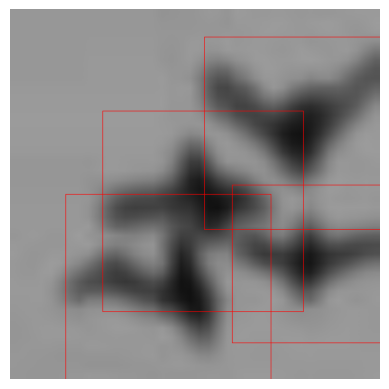

(640, 640, 3)

In [540]:
boxes = cv2.imread("Instance_seg\emergence_4_2.jpg")
boxes = cv2.resize(boxes, (640, 640))

with open(r'Instance_seg\emergence_4_2.txt', 'r') as f:
    file_contents = f.read()
    words = file_contents.split()
    bat_class = words[0]
    bounding_boxes = words[1:]
    x_ys= bounding_boxes[:len(bounding_boxes)//2]
    w_hs= bounding_boxes[len(bounding_boxes)//2:]
    positions = np.asarray([np.asarray([x_ys[i], x_ys[i+1]]) for i in range(0, len(x_ys), 2)]).astype(float)
    dimensions = np.asarray([np.asarray([w_hs[i], w_hs[i+1]]) for i in range(0, len(w_hs), 2)]).astype(float)
    positions=(positions*boxes.shape[0]).astype(int)
    dimensions=(dimensions*boxes.shape[0]).astype(int)
    for (x,y), (w,h) in zip(positions, dimensions):
        cv2.rectangle(boxes, (x,y), (x+w, y+h), (255), 1)
quickshow(boxes)
boxes.shape